<a href="https://colab.research.google.com/github/MinhQuan0000/MV_final/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from google.colab import drive
import cv2
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-3-f5d121dede1c>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_TB = np.zeros(3, dtype=np.float)


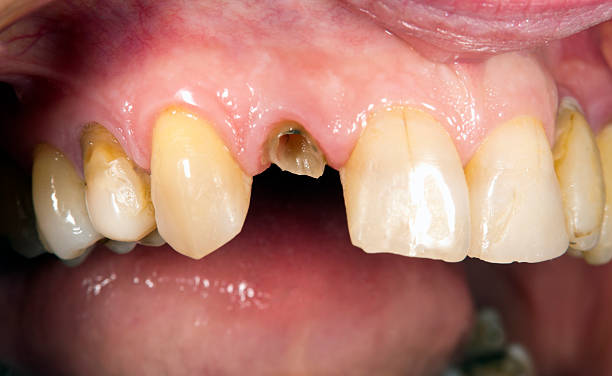

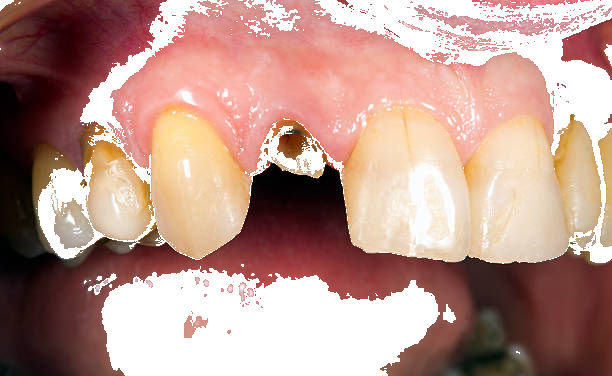

In [ ]:
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

def segment_color_image(image_path, threshold=50):
    # Read the color image using OpenCV
    img_OpenCV = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Create an image to store the segmentation result
    SegmentationIMG = Image.new("RGB", (img_OpenCV.shape[1], img_OpenCV.shape[0]))
    # Get image dimensions
    Width, Height = img_OpenCV.shape[1], img_OpenCV.shape[0]
    # Initialize cumulative values for average color
    a_TB = np.zeros(3, dtype=np.float)
    # Calculate average pixel value for the entire image
    for x in range(Width):
        for y in range(Height):
            pixel_value = img_OpenCV[y, x]
            a_TB += pixel_value
    # Calculate the size of the vector a: Size = Width * Height
    Size = Width * Height
    a_TB /= Size
    # Loop through all pixels in the image
    for a in range(Width):
        for b in range(Height):
            pixel_value = img_OpenCV[b, a]
            # Calculate Euclidean Distance D(z, a)
            D = np.linalg.norm(pixel_value - a_TB)
            # Compare with the threshold to determine if z(x, y) is background or object
            if D <= threshold:
                SegmentationIMG.putpixel((a, b), (255, 255, 255))  # White pixel
            else:
                SegmentationIMG.putpixel((a, b), tuple(pixel_value))
    # Convert the segmentation result from PIL to OpenCV for display
    Segmentation = np.array(SegmentationIMG)
    # Display the images using Colab's cv2_imshow
    cv2_imshow(img_OpenCV)
    cv2_imshow(Segmentation)

# Example usage
image_path = '/content/drive/MyDrive/XLA_S/Training/caries/100.jpg'
segment_color_image(image_path)


<ipython-input-4-5252bda963cd>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_TB = np.zeros(3, dtype=np.float)


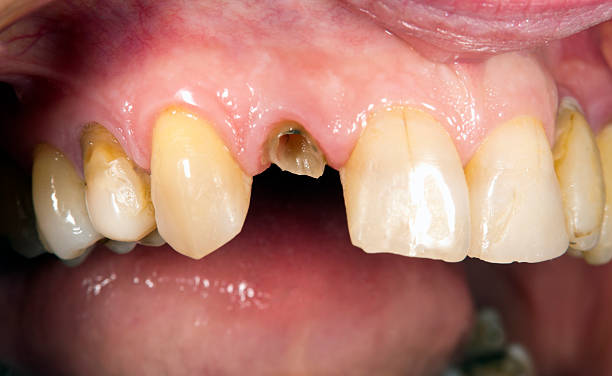

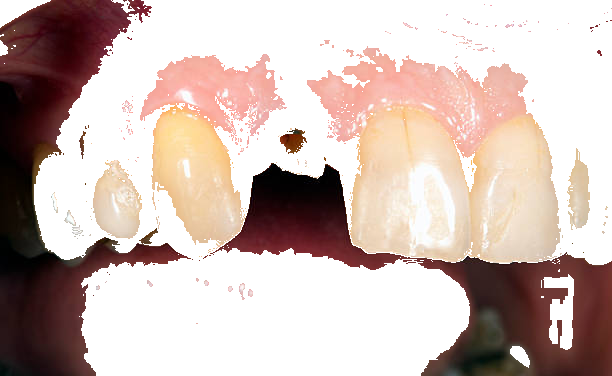

In [ ]:
def segment_color_image(image_path, threshold=100):
    # Read the color image using OpenCV
    img_OpenCV = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Create an image to store the segmentation result
    SegmentationIMG = Image.new("RGB", (img_OpenCV.shape[1], img_OpenCV.shape[0]))
    # Get image dimensions
    Width, Height = img_OpenCV.shape[1], img_OpenCV.shape[0]
    # Initialize cumulative values for average color
    a_TB = np.zeros(3, dtype=np.float)
    # Calculate average pixel value for the entire image
    for x in range(Width):
        for y in range(Height):
            pixel_value = img_OpenCV[y, x]
            a_TB += pixel_value
    # Calculate the size of the vector a: Size = Width * Height
    Size = Width * Height
    a_TB /= Size
    # Loop through all pixels in the image
    for a in range(Width):
        for b in range(Height):
            pixel_value = img_OpenCV[b, a]
            # Calculate Euclidean Distance D(z, a)
            D = np.linalg.norm(pixel_value - a_TB)
            # Compare with the threshold to determine if z(x, y) is background or object
            if D <= threshold:
                SegmentationIMG.putpixel((a, b), (255, 255, 255))  # White pixel
            else:
                SegmentationIMG.putpixel((a, b), tuple(pixel_value))
    # Convert the segmentation result from PIL to OpenCV for display
    Segmentation = np.array(SegmentationIMG)
    # Display the images using Colab's cv2_imshow
    cv2_imshow(img_OpenCV)
    cv2_imshow(Segmentation)

# Example usage
image_path = '/content/drive/MyDrive/XLA_S/Training/caries/100.jpg'
segment_color_image(image_path)


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow

# Hàm segment_color_image đã được định nghĩa ở phần trước

def segment_color_image(image, threshold=100):
    # Create an image to store the segmentation result
    SegmentationIMG = Image.new("RGB", (image.shape[1], image.shape[0]))
    # Initialize cumulative values for average color
    a_TB = np.zeros(3, dtype=np.float)
    # Calculate average pixel value for the entire image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            pixel_value = image[y, x]
            a_TB += pixel_value
    # Calculate the size of the vector a: Size = Width * Height
    Size = image.shape[1] * image.shape[0]
    a_TB /= Size
    # Loop through all pixels in the image
    for a in range(image.shape[1]):
        for b in range(image.shape[0]):
            pixel_value = image[b, a]
            # Calculate Euclidean Distance D(z, a)
            D = np.linalg.norm(pixel_value - a_TB)
            # Compare with the threshold to determine if z(x, y) is background or object
            if D <= threshold:
                SegmentationIMG.putpixel((a, b), (255, 255, 255))  # White pixel
            else:
                SegmentationIMG.putpixel((a, b), tuple(pixel_value))
    # Convert the segmentation result from PIL to OpenCV
    segmented_image = np.array(SegmentationIMG)
    return segmented_image

def save_segmented_images(directory_path, output_directory):
    image_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path)]
    for img_path in image_paths:
        print(f"Processing image: {img_path}")
        img_OpenCV = cv2.imread(img_path, cv2.IMREAD_COLOR)
        segmented_image = segment_color_image(img_OpenCV)

        # Lấy tên của thư mục cuối cùng trong đường dẫn
        folder_name = os.path.basename(os.path.dirname(img_path))
        # Lưu hình ảnh sau khi phân đoạn vào thư mục đích tương ứng
        output_path = os.path.join(output_directory, folder_name, os.path.basename(img_path))
        cv2.imwrite(output_path, cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

# Set paths
train_dir = '/content/drive/MyDrive/XLA_S/Training'
output_segmented_dir = '/content/drive/MyDrive/XLA_S/Segmented'

# Tạo thư mục đích để lưu hình ảnh sau khi phân đoạn
os.makedirs(os.path.join(output_segmented_dir, 'Caries'), exist_ok=True)
os.makedirs(os.path.join(output_segmented_dir, 'No Caries'), exist_ok=True)

# Process, save, and segment caries images in the training directory
caries_train_dir = os.path.join(train_dir, 'caries')
save_segmented_images(caries_train_dir, os.path.join(output_segmented_dir, 'Caries'))

# Process, save, and segment no caries images in the training directory
no_caries_train_dir = os.path.join(train_dir, 'No Caries')
save_segmented_images(no_caries_train_dir, os.path.join(output_segmented_dir, 'No Caries'))


Processing image: /content/drive/MyDrive/XLA_S/Training/caries/0.jpg


<ipython-input-5-a79289637b6d>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_TB = np.zeros(3, dtype=np.float)


Processing image: /content/drive/MyDrive/XLA_S/Training/caries/1.jpg
Processing image: /content/drive/MyDrive/XLA_S/Training/caries/10.jpg
Processing image: /content/drive/MyDrive/XLA_S/Training/caries/100.jpg
Processing image: /content/drive/MyDrive/XLA_S/Training/caries/101.jpg
Processing image: /content/drive/MyDrive/XLA_S/Training/caries/102.jpg
Processing image: /content/drive/MyDrive/XLA_S/Training/caries/103.jpg
Processing image: /content/drive/MyDrive/XLA_S/Training/caries/104.jpg


In [ ]:
# Hàm segment_color_image đã được định nghĩa ở phần trước
import os
import cv2

def add_labels_and_save(directory_path, output_directory, label):
    image_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path)]
    for img_path in image_paths:
        print(f"Processing image: {img_path}")
        img_OpenCV = cv2.imread(img_path, cv2.IMREAD_COLOR)
        segmented_image = segment_color_image(img_OpenCV)

        # Gắn nhãn lên hình ảnh
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (10, 30)  # Vị trí để hiển thị nhãn
        font_scale = 1
        font_color = (255, 255, 255)  # Màu trắng
        font_thickness = 2

        cv2.putText(segmented_image, label, position, font, font_scale, font_color, font_thickness)

        # Lưu hình ảnh sau khi gắn nhãn vào thư mục đích
        label_dir = os.path.join(output_directory, label)
        os.makedirs(label_dir, exist_ok=True)
        output_path = os.path.join(label_dir, os.path.basename(img_path))
        cv2.imwrite(output_path, cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))

# Set paths
output_segmented_dir = '/content/drive/MyDrive/XLA_S/Segmented'

# Tạo thư mục đích để lưu hình ảnh sau khi gắn nhãn
os.makedirs(output_segmented_dir, exist_ok=True)

# Process, save, and label Caries images in the segmented directory
caries_segmented_dir = os.path.join(output_segmented_dir, 'Caries')
add_labels_and_save(caries_segmented_dir, output_segmented_dir, label="Caries")

# Process, save, and label No Caries images in the segmented directory
no_caries_segmented_dir = os.path.join(output_segmented_dir, 'No Caries')
add_labels_and_save(no_caries_segmented_dir, output_segmented_dir, label="No Caries")


In [ ]:
# Model with regularization


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Set paths
train_dir = '/content/drive/MyDrive/XLA_S/Segmented'
batch_size = 128
input_shape = (224, 224, 3)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)




In [ ]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.round(predictions)

In [ ]:
# Suppress UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Remove the filter after using
warnings.filterwarnings("default", category=UndefinedMetricWarning)

In [ ]:
# Plot learning curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Load a few test images and predict their labels
num_images_to_predict = 30  # Change this to the number of images you want to predict

# Get a few test images and their true labels
test_images, true_labels = next(test_generator)

# Predict labels for the test images
predicted_labels = model.predict(test_images)

# Convert predicted labels to binary (0 or 1)
predicted_labels = np.round(predicted_labels)

# Define class names
class_names = ['Caries', 'No Caries']

# Define the number of rows and columns for subplots
num_rows = 10
num_cols = 3

# Display the test images along with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {class_names[int(true_labels[i])]}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
plt.show()

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/XLA_S/segmentation2_model.h5')